In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import yfinance as yf
from google.colab import drive
# drive.mount('/content/gdrive')
ticker_symbol = 'CSL.AX'  # CSL AUS
data = yf.download(ticker_symbol, period="max")

# Save the data as a CSV file
data.to_csv(f"{ticker_symbol}.csv")

[*********************100%%**********************]  1 of 1 completed


## Data Cleaning & Visualisation

In [ ]:
historical_CSL=pd.read_csv(f"{ticker_symbol}.csv")
historical_CSL['Date']=pd.to_datetime(historical_CSL['Date'])
historical_CSL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1994-05-31,0.826666,0.826666,0.826666,0.826666,0.505282,0.0
1,1994-06-01,0.826666,0.826666,0.826666,0.826666,0.505282,0.0
2,1994-06-02,0.826666,0.826666,0.826666,0.826666,0.505282,0.0
3,1994-06-03,0.826666,0.826666,0.826666,0.826666,0.505282,0.0
4,1994-06-06,0.826666,0.826666,0.826666,0.826666,0.505282,0.0


We see a lot of zero volume reduntant data points at the start that should be dropped off.

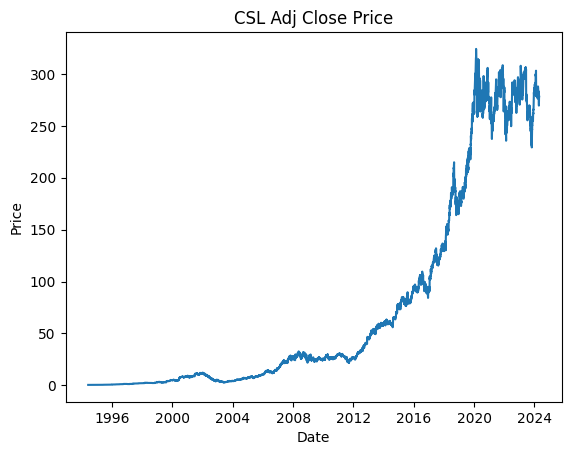

In [ ]:
plt.plot( historical_CSL['Date'],historical_CSL["Adj Close"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("CSL Adj Close Price")
plt.show()


### Cleaned Data Plot

In [ ]:
zero_vol_trades=[]
for i in range(0, historical_CSL.shape[0]):
    if historical_CSL['Volume'][i]==0:
        zero_vol_trades.append(i)
redundant_rows=0

for i in range(1, len(zero_vol_trades)):
    if zero_vol_trades[i-1]+1!=zero_vol_trades[i]:
        redundant_rows=i
        break

CSL=historical_CSL.iloc[redundant_rows+1:]
CSL.head()


,Date,Open,High,Low,Close,Adj Close,Volume
1199,1999-01-04,4.750000,4.750000,4.660000,4.666666,3.219596,237768.0
1200,1999-01-05,4.666666,4.666666,4.616666,4.616666,3.185102,472977.0
1201,1999-01-06,4.666666,4.666666,4.620000,4.650000,3.208099,400893.0
1202,1999-01-07,4.700000,4.700000,4.660000,4.700000,3.242594,506640.0
1203,1999-01-08,4.666666,4.666666,4.616666,4.666666,3.219596,4712871.0


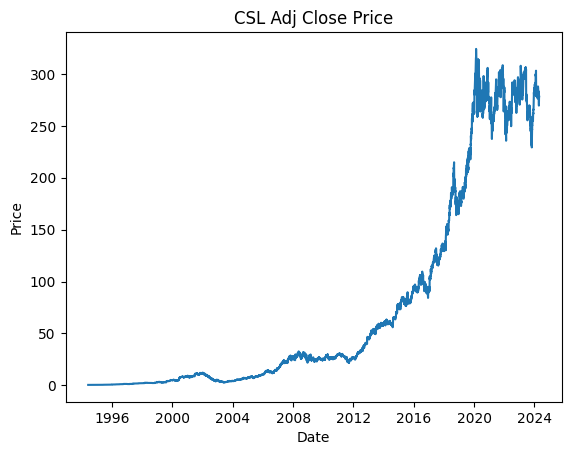

In [ ]:
plt.plot( historical_CSL['Date'],historical_CSL["Adj Close"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("CSL Adj Close Price")
plt.show()

## Plotted Log Returns

<ipython-input-9-1b2644e9d2e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CSL["Log Return"] = np.log(CSL["Close"] / CSL["Close"].shift(1))


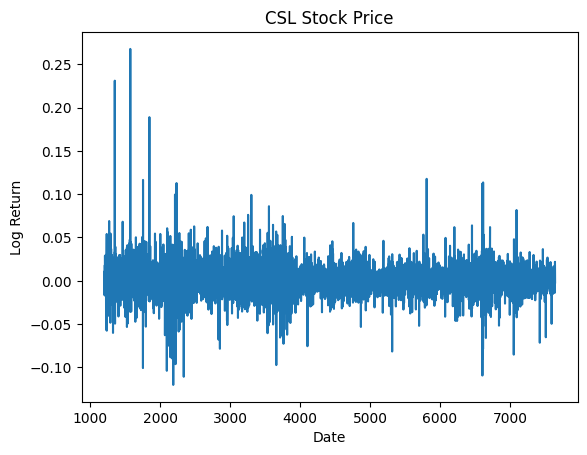

In [ ]:
CSL["Log Return"] = np.log(CSL["Close"] / CSL["Close"].shift(1))
CSL_Log_Returns=CSL['Log Return'][1:]

CSL_Log_Returns.plot()
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.title("CSL Stock Price")
plt.show()


## QQ Plot

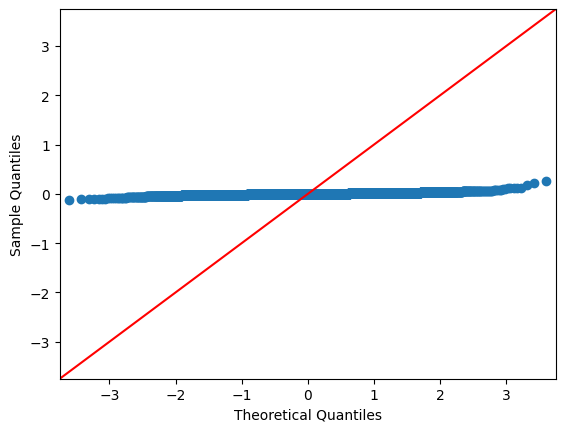

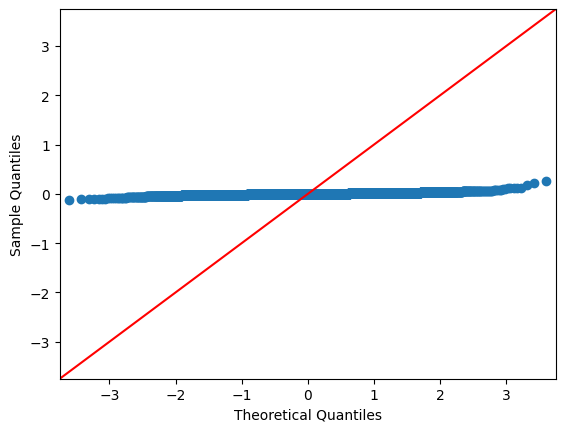

In [ ]:
import statsmodels.api as sm
sm.qqplot(CSL_Log_Returns, line ='45')


## Hist Plot of Log-Returns

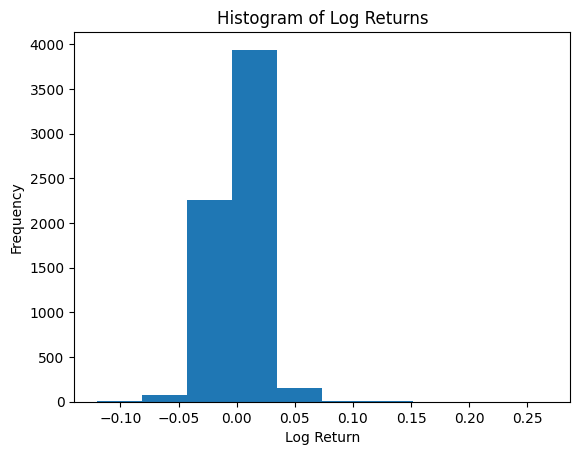

In [ ]:

# Histogram
plt.figure()
plt.hist(CSL_Log_Returns)
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.title("Histogram of Log Returns")
plt.show()


## Tests for Normality
Jarque_bera & Kolmogorov-Smirnov

In [ ]:

from scipy import stats

stat, p_value = stats.jarque_bera(CSL_Log_Returns)
print("Jarque-Berra Test p-value:", p_value)

# Kolmogorov-Smirnov Test
statistic, p_value = stats.kstest(CSL_Log_Returns, 'norm')
print("Kolmogorov-Smirnov Test p-value:", p_value)


Jarque-Berra Test p-value: 0.0
Kolmogorov-Smirnov Test p-value: 0.0


Since p-value for both is near zero, the Log Returns certainly are not normally distributed

## Test for Auto-Correlation

In [ ]:
Auto_correlation_with_lag1=np.corrcoef(CSL_Log_Returns[:-1], CSL_Log_Returns[1:])[0,1]
Auto_correlation_with_lag1


0.012394177146520911

Data is very weakly auto-correlated, thus the auto-correlation can be ignored

## Volatility Measures

### Standard Volatility Measure: Standard Deviation of Log-Returns

In [ ]:
volatility = CSL_Log_Returns.std() * np.sqrt(252)  # Annualized volatility
print("Estimated Historical Volatility:", volatility)

Estimated Historical Volatility: 0.2843671130095049


### GARCH Volatility

In [ ]:
!pip install arch
from arch import arch_model

def estimate_garch_volatility(data, forecast_horizon, p=1, q=1):
  """
  Estimates time-varying volatility using GARCH(p, q) model.

  Args:
      data: A NumPy array containing the time series data.
      p: The autoregressive (AR) lag order (default: 1).
      q: The moving average (MA) lag order for conditional variance (default: 1).

  Returns:
      A NumPy array containing the estimated conditional standard deviations (volatility).
  """

  # Define the GARCH model
  am = arch_model(data, mean="constant", vol="GARCH", p=p, q=q)

  # Fit the model to the data
  am_fit = am.fit(disp=False)  # Suppress output during fitting

  # Extract the estimated conditional standard deviations (volatility)
  forecast=am_fit.forecast(horizon=forecast_horizon)
  volatility=np.sqrt(np.mean(forecast.variance.iloc[0].values))* np.sqrt(252)
  return volatility

garch_volatility=estimate_garch_volatility(CSL_Log_Returns*100,25)/100
print('GARCH Volatility:', garch_volatility)


GARCH Volatility: 0.2001357975992009


## Option Pricing

In [ ]:

# There are no active call/put options curretly trading on Australian Exchange for this stock. So strike price is arbitrary
Aus_bond_return=0.0435 #3 month
spot_price=278.45
strike_price=275
risk_free_rate=Aus_bond_return
volatility=volatility
time_to_maturity=25/252 # remaining operational days/ annual operational days
option_type='Call'


### Simulated GBM

#### Drift Calculation

In [ ]:

# Calculating drift for GBM
idx = np.isfinite(np.array([i for i in range(0, len(historical_CSL['Adj Close'].to_list()))])) & np.isfinite(np.log(historical_CSL['Adj Close'].to_list()))
ab = np.polyfit(np.array([i for i in range(0, len(historical_CSL['Adj Close'].to_list()))])[idx], np.log(historical_CSL['Adj Close'].to_list())[idx], 1)
drift=ab[0]
print("drift is: ",drift)

drift is:  0.0008167736637308378


#### Simulated Pricing

In [ ]:
def simulated_GBM_option_pricing(spot_price, strike_price, risk_free_rate, volatility, drift, time_to_maturity, option_type, no_of_simulations):
  """
  Calculates option price using simulated GBM model.

  Args:
      spot_price: Current stock price.
      strike_price: Strike price of the option.
      risk_free_rate: Risk-free interest rate.
      volatility: Stock price volatility.
      drift: Value of drift used in GBM.
      time_to_maturity: Time to maturity of the option (in years).
      option_type: "Call" or "Put".
      no_of_simulations: Number of times the simulation should run.

  Returns:
      Option price based on simulated GBM model.
  """

  # Assign parameters
  S0 = spot_price
  drift = drift
  vol = volatility
  N = int(time_to_maturity*252-1)
  sims = no_of_simulations
  T = time_to_maturity
  t = np.linspace(0, T, N+1)
  t = t.reshape((len(t),1))
  dt = t[1]-t[0]

  # simulate and plot price movement
  X = np.random.normal(0, np.sqrt(dt), (N, sims))
  X0 = np.zeros_like(X[0:1])
  X = np.vstack([X0, X])
  dABM = drift*dt+vol*X
  ABM = np.cumsum(dABM, axis = 0)
  GBM = S0*np.exp(ABM)
  plt.figure(figsize = (10,5))
  plt.plot(t, GBM)
  plt.xlabel("Time (in years)")
  plt.ylabel("Simulated Stock Price")
  plt.plot(t, S0*np.exp(drift*t), color = 'black', linewidth = 3)
  plt.show()

  # calculate option price
  if option_type.lower()=='call':
    returns=[max(GBM[-1][i]-strike_price, 0) for i in range(0, GBM.shape[1])]
  elif option_type.lower()=='put':
    returns=[max(-GBM[-1][i]+strike_price, 0) for i in range(0, GBM.shape[1])]
  else:
    print('Invalid option type')
  expected_return=np.mean(returns)
  option_price=expected_return/np.exp(risk_free_rate* time_to_maturity)
  return option_price

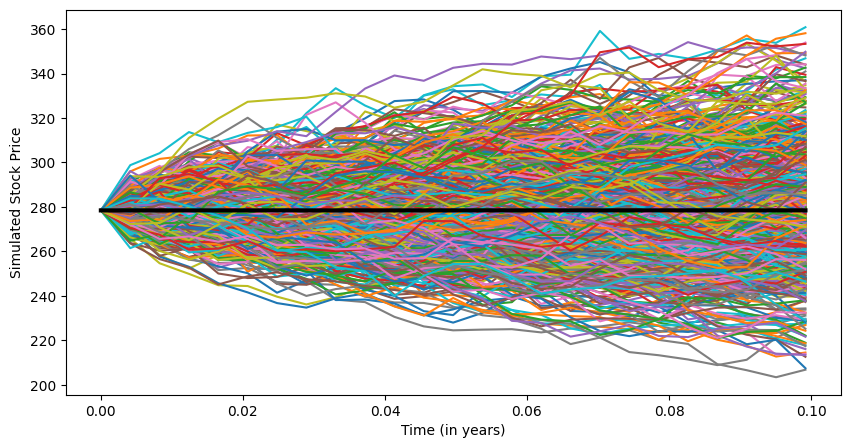

Option Price for standard volatility measure using simulated GBM would be:  12.499952851372736 





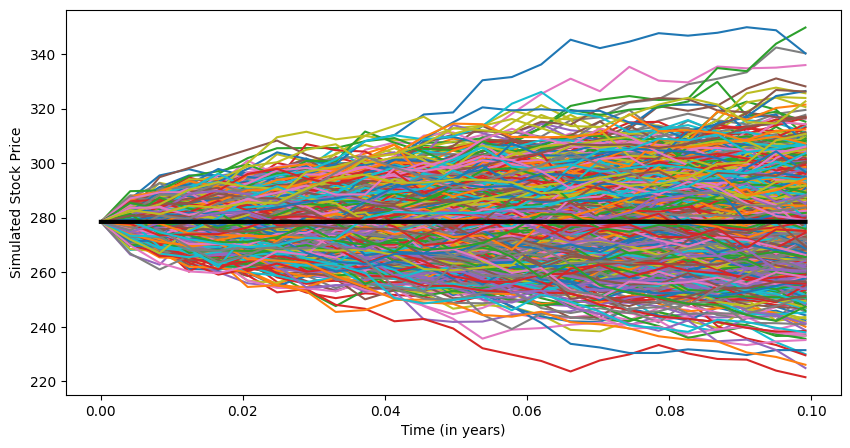

Option Price for GARCH volatility measure using simulated GBM would be:  8.699509053920748


In [ ]:
no_of_simulations=1000
# for standard volatility measure
sGBM=simulated_GBM_option_pricing(spot_price, strike_price, risk_free_rate, volatility, drift, time_to_maturity, option_type, no_of_simulations)
print('Option Price for standard volatility measure using simulated GBM would be: ', sGBM, '\n\n\n')
# for garch volatility
gGBM=simulated_GBM_option_pricing(spot_price, strike_price, risk_free_rate, garch_volatility, drift, time_to_maturity, option_type, no_of_simulations)
print('Option Price for GARCH volatility measure using simulated GBM would be: ', gGBM)

### CRR Option Pricing

In [ ]:

def crr_option_price( spot_price, strike_price, risk_free_rate, volatility, time_to_maturity, option_type, steps ):
  """
  Calculates option price using the CRR binomial model.

  Args:
      spot_price: Current stock price.
      strike_price: Strike price of the option.
      risk_free_rate: Risk-free interest rate.
      volatility: Stock price volatility.
      time_to_maturity: Time to maturity of the option (in years).
      option_type: "Call" or "Put".
      steps: Number of steps in the binomial tree.

  Returns:
      Option price based on the CRR model.
  """

  dt=float(time_to_maturity/steps)
  u=np.exp(volatility*(dt**0.5))
  d=1/u
  p_hat=(np.exp(risk_free_rate*dt)-d)/(u-d)
  c=0
  if option_type.lower()=='call':
    for i in range(steps+1):
      c=c+nCr(steps,i)*(p_hat**i)*((1-p_hat)**(steps-i))*max(0,((u**i)*(d**(steps-i))*spot_price)-strike_price)
    return c/((1+risk_free_rate)**steps)
  elif option_type.lower()=='put':
    for i in range(steps+1):
      c=c+nCr(steps,i)*(p_hat**i)*((1-p_hat)**(steps-i))*max(0,-((u**i)*(d**(steps-i))*spot_price)+strike_price)
    return c/((1+risk_free_rate)**steps)
  else:
    print('Invalid option type')
    return

def nCr(n,r):
    return math.factorial(n)/(math.factorial(r)*math.factorial(n-r))


In [ ]:

sCRR=crr_option_price(spot_price, strike_price, risk_free_rate, volatility, time_to_maturity, option_type, int(time_to_maturity*252)-1)
print('Option Price for standard volatility measure using CRR model would be: ', sCRR,'\n')
gCRR=crr_option_price(spot_price, strike_price, risk_free_rate, garch_volatility, time_to_maturity, option_type, int(time_to_maturity*252)-1)
print('Option Price for GARCH volatility measure using CRR model would be: ', gCRR,'\n')


Option Price for standard volatility measure using CRR model would be:  4.493619493017998 

Option Price for GARCH volatility measure using CRR model would be:  3.460544944465391 



### Black-Scholes Model

In [ ]:
def black_scholes_option_price(spot_price, strike_price, risk_free_rate, volatility, time_to_maturity, option_type):
  """
  Calculates option price using the Black-Scholes model.

  Args:
      spot_price: Current stock price.
      strike_price: Strike price of the option.
      risk_free_rate: Risk-free interest rate.
      volatility: Stock price volatility.
      time_to_maturity: Time to maturity of the option (in years).
      option_type: "Call" or "Put".

  Returns:
      Option price based on the Black-Scholes model.
  """

  d1 = (math.log(spot_price / strike_price) + (risk_free_rate + volatility**2 / 2) * time_to_maturity) / (volatility * math.sqrt(time_to_maturity))
  d2 = d1 - volatility * math.sqrt(time_to_maturity)

  if option_type.lower() == "call":
    return spot_price * normcdf(d1) - strike_price * math.exp(-risk_free_rate * time_to_maturity) * normcdf(d2)
  elif option_type.lower()=="put":
    return strike_price * math.exp(-risk_free_rate * time_to_maturity) * normcdf(-d2) - spot_price * (1 - normcdf(-d1))
  else:
    print('Invalid option type')
    return

def normcdf(x):
    return norm.cdf(x)


In [ ]:
sBSM=black_scholes_option_price(spot_price, strike_price, risk_free_rate, volatility, time_to_maturity, option_type)
print('Option Price for standard volatility measure using simulated Black-Scholes Model would be: ', sBSM,'\n')
gBSM=black_scholes_option_price(spot_price, strike_price, risk_free_rate, garch_volatility, time_to_maturity, option_type)
print('Option Price for garch volatility measure using simulated Black-Scholes Model would be: ', gBSM,'\n')

Option Price for standard volatility measure using simulated Black-Scholes Model would be:  12.353155663777159 

Option Price for garch volatility measure using simulated Black-Scholes Model would be:  9.50470030146596 

